In [36]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import numpy as np

df = pd.read_parquet('../data/devlogs.parquet')

# No of Devlogs created per Date

This chart shows the number of devlogs created on each date using the `created_date` column .

In [37]:
date_series = pd.to_datetime(df['created_date'], errors='coerce')

counts = (
    pd.DataFrame({'date': date_series.dt.date})
      .dropna(subset=['date'])
      .groupby('date')
      .size()
      .reset_index(name='devlog_count')
      .sort_values('date')
)

counts['date'] = pd.to_datetime(counts['date'])
counts['rolling_7d'] = counts['devlog_count'].rolling(7, min_periods=1).mean()

fig = px.bar(
    counts, x='date', y='devlog_count',
    title='Devlogs per Day',
    labels={'date': 'Date', 'devlog_count': 'Devlogs'},
    color_discrete_sequence=['#636EFA']
)

fig.add_scatter(
    x=counts['date'], y=counts['rolling_7d'],
    name='7-day average', mode='lines',
    line=dict(color='#EF553B', width=2)
)

fig.update_traces(hovertemplate='Date=%{x|%Y-%m-%d}<br>Devlogs=%{y}')
fig.update_layout(
    template='plotly_white', hovermode='x unified', bargap=0.15,
    height=450, margin=dict(l=40, r=20, t=60, b=40),
    xaxis=dict(title='Date', tickformat='%b %Y',
               showgrid=False, rangeslider=dict(visible=True)),
    yaxis=dict(title='Devlogs', showgrid=True, gridcolor='rgba(0,0,0,0.08)')
)
fig.show()

# Average time per devlog (minutes)

Compute and display the average of `time_minutes`.


In [38]:
avg_minutes = pd.to_numeric(df['time_minutes'], errors='coerce').mean()
print(f"Average time per devlog: {avg_minutes:.2f} minutes")

Average time per devlog: 179.54 minutes


# Top projects and devlogs by time

Two horizontal bar charts: total time per project (top 15) and individual devlogs with the highest time (top 15).


In [39]:
TOP_N = 12

_df = df.copy()
_df['time_minutes_num'] = pd.to_numeric(_df['time_minutes'], errors='coerce')
_df = _df.dropna(subset=['time_minutes_num'])

proj_agg = (
    _df.groupby(['project_id', 'project_title'], dropna=False,
                observed=False)['time_minutes_num']
    .sum()
    .reset_index()
    .sort_values('time_minutes_num', ascending=False)
    .head(TOP_N)
)

proj_title = proj_agg['project_title'].astype(
    'object').fillna('(untitled)').astype(str).str.slice(0, 38)
proj_agg['project_label'] = proj_title + \
    ' [' + proj_agg['project_id'].astype(str) + ']'

_dev_title = _df['project_title'].astype(
    'object').fillna('(untitled)').astype(str)
_df['devlog_label'] = (_dev_title.str.slice(
    0, 28) + ' | #' + _df['devlog_id'].astype(str))

devlog_top = (
    _df[['devlog_id', 'devlog_label', 'time_minutes_num']]
    .sort_values('time_minutes_num', ascending=False)
    .head(TOP_N)
)

height = max(len(proj_agg), len(devlog_top)) * 44 + 260

fig = make_subplots(
    rows=1, cols=2, column_widths=[0.5, 0.5],
    subplot_titles=(
        'Top Projects by Total Time (minutes)',
        'Top Devlogs by Time (minutes)'
    )
)

fig.add_trace(
    go.Bar(
        x=proj_agg['time_minutes_num'][::-1],
        y=proj_agg['project_label'][::-1],
        orientation='h',
        marker_color='#636EFA',
        hovertemplate='%{y}<br>Total=%{x:.2f} min'
    ), row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=devlog_top['time_minutes_num'][::-1],
        y=devlog_top['devlog_label'][::-1],
        orientation='h',
        marker_color='#EF553B',
        hovertemplate='%{y}<br>Time=%{x:.2f} min'
    ), row=1, col=2
)

fig.update_layout(
    template='plotly_white', height=height,
    margin=dict(l=220, r=30, t=80, b=40),
    showlegend=False,
    bargap=0.25
)
fig.update_xaxes(title_text='Minutes', row=1, col=1)
fig.update_xaxes(title_text='Minutes', row=1, col=2)
fig.update_yaxes(title_text='Project', row=1, col=1,
                 automargin=True, tickfont=dict(size=11))
fig.update_yaxes(title_text='Devlog', row=1, col=2,
                 automargin=True, tickfont=dict(size=11))
fig.show()

# When are devlogs posted?

Heatmap of devlog counts by day of week and hour (UTC).


In [40]:
def to_day_name(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
                   3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
        return s.map(mapping)
    return s.astype(str)


if {'created_dow', 'created_hour_utc'}.issubset(df.columns):
    dow = to_day_name(df['created_dow'])
    hour = pd.to_numeric(df['created_hour_utc'], errors='coerce')
else:
    ts = pd.to_datetime(df['created_at'], errors='coerce', utc=True)
    dow = ts.dt.day_name()
    hour = ts.dt.hour

_counts = (
    pd.DataFrame({'dow': dow, 'hour': hour})
      .dropna()
      .assign(hour=lambda d: pd.to_numeric(d['hour'], errors='coerce').astype('Int64'))
      .dropna()
      .assign(hour=lambda d: d['hour'].astype(int).clip(0, 23))
      .groupby(['dow', 'hour'], observed=False)
      .size()
      .reset_index(name='count')
)

dow_order = ['Monday', 'Tuesday', 'Wednesday',
             'Thursday', 'Friday', 'Saturday', 'Sunday']
hour_order = list(range(24))

pivot = (
    _counts.pivot_table(index='dow', columns='hour',
                        values='count', fill_value=0)
    .reindex(index=dow_order, columns=hour_order, fill_value=0)
)

fig = px.imshow(
    pivot,
    labels=dict(x='Hour (UTC)', y='Day of Week', color='Devlogs'),
    color_continuous_scale='Blues',
    aspect='auto',
    title='Devlogs by Day of Week and Hour (UTC)'
)
fig.update_layout(height=420, template='plotly_white',
                  margin=dict(l=60, r=30, t=60, b=40))
fig.show()

# Growth of devlogs over time

Cumulative total of devlogs across dates.


In [41]:
_ds = pd.to_datetime(df['created_date'], errors='coerce')
series = (
    pd.DataFrame({'date': _ds.dt.date})
      .dropna()
      .groupby('date')
      .size()
      .reset_index(name='count')
      .sort_values('date')
)
series['date'] = pd.to_datetime(series['date'])
series['cumulative'] = series['count'].cumsum()

fig = px.area(series, x='date', y='cumulative',
              title='Cumulative Devlogs',
              labels={'date': 'Date', 'cumulative': 'Total Devlogs'},
              color_discrete_sequence=['#19A974'])
fig.update_layout(template='plotly_white', height=420,
                  margin=dict(l=40, r=30, t=60, b=40))
fig.show()

# Engagement vs time spent

Which devlogs have high time and high engagement?


In [42]:
_df = df.copy()
_df['time_minutes_num'] = pd.to_numeric(_df['time_minutes'], errors='coerce')

if 'engagement' in _df.columns:
    _df['engagement_num'] = pd.to_numeric(_df['engagement'], errors='coerce')
elif 'likes_count' in _df.columns:
    _df['engagement_num'] = pd.to_numeric(_df['likes_count'], errors='coerce')
else:
    _df['engagement_num'] = pd.NA

if 'likes_count' in _df.columns:
    _df['likes_size'] = pd.to_numeric(
        _df['likes_count'], errors='coerce').fillna(0).clip(lower=0)
else:
    _df['likes_size'] = pd.Series([None] * len(_df), index=_df.index)


plot_df = _df.dropna(subset=['time_minutes_num', 'engagement_num']).copy()

kwargs = {}
if plot_df['likes_size'].notna().any():
    kwargs['size'] = 'likes_size'
    kwargs['size_max'] = 24

fig = px.scatter(
    plot_df,
    x='time_minutes_num', y='engagement_num',
    hover_data={'project_title': True, 'devlog_id': True,
                'time_minutes_num': ':.1f', 'engagement_num': ':.1f'},
    labels={'time_minutes_num': 'Time (minutes)', 'engagement_num': 'Engagement',
            'has_attachment_bool': 'Has attachment'},
    title='Engagement vs Time Spent',
    **kwargs
)
fig.update_layout(template='plotly_white', height=450,
                  margin=dict(l=40, r=30, t=60, b=40))
fig.show()

# Distribution of time

How is the time spread out?


In [43]:
s = pd.to_numeric(df['time_minutes'], errors='coerce')
fig = px.histogram(
    s.dropna(), nbins=40,
    title='Distribution of Time per Devlog',
    labels={'value': 'Minutes', 'count': 'Devlogs'},
    color_discrete_sequence=['#636EFA']
)
fig.update_traces(marker_line_color='white', marker_line_width=0.5)
fig.update_layout(template='plotly_white', bargap=0.05,
                  height=400, xaxis_title='Minutes', yaxis_title='Devlogs')
fig.show()

# Average time per Category

Which category has the highest time?


In [44]:
_df = df.copy()
_df['time_minutes_num'] = pd.to_numeric(_df['time_minutes'], errors='coerce')

cat = (
    _df.dropna(subset=['category', 'time_minutes_num'])
       .groupby('category', observed=False)['time_minutes_num']
       .mean()
       .reset_index(name='avg_minutes')
       .sort_values('avg_minutes', ascending=False)
)

fig = px.bar(
    cat, x='category', y='avg_minutes',
    title='Average Time by Category',
    labels={'category': 'Category', 'avg_minutes': 'Avg Minutes'},
    color_continuous_scale='Viridis'
)
fig.update_layout(template='plotly_white', height=420, xaxis_tickangle=-30)
fig.show()

# Category and Attachment Type Distribution

Two separate donut charts showing the share by `category` and by `attachment_ext` (top groups, others combined). Each chart has its own legend.


In [45]:
K = 10

_df = df.copy()


def topk_counts(series: pd.Series, k: int):
    vc = (series.astype(str)
                .str.strip()
                .replace({'': pd.NA, 'None': pd.NA, 'nan': pd.NA})
                .dropna()
                .value_counts())
    if len(vc) <= k:
        labels = vc.index.tolist()
        values = vc.values.tolist()
    else:
        top = vc.head(k)
        others = vc.iloc[k:].sum()
        labels = top.index.tolist() + ['Other']
        values = top.values.tolist() + [others]
    return labels, values


cat_labels, cat_values = topk_counts(
    _df.get('category', pd.Series(dtype=object)), K)
att_labels, att_values = topk_counts(
    _df.get('attachment_ext', pd.Series(dtype=object)), K)

fig_cat = go.Figure(go.Pie(
    labels=cat_labels, values=cat_values, hole=0.5, name='Category',
    textinfo='label+percent', hovertemplate='%{label}: %{value} devlogs (%{percent})'
))
fig_cat.update_layout(
    title_text='Category Distribution', template='plotly_white', height=420,
    showlegend=False
)
fig_cat.show()

fig_att = go.Figure(go.Pie(
    labels=att_labels, values=att_values, hole=0.5, name='Attachment Ext',
    textinfo='none', hovertemplate='%{label}: %{value} devlogs (%{percent})'
))
fig_att.update_layout(
    title_text='Attachment Extension Distribution', template='plotly_white', height=420,
    legend=dict(orientation='h', yanchor='bottom',
                y=1.02, xanchor='right', x=1)
)
fig_att.show()

# Text analysis

Some cool text analysis coz i am bored


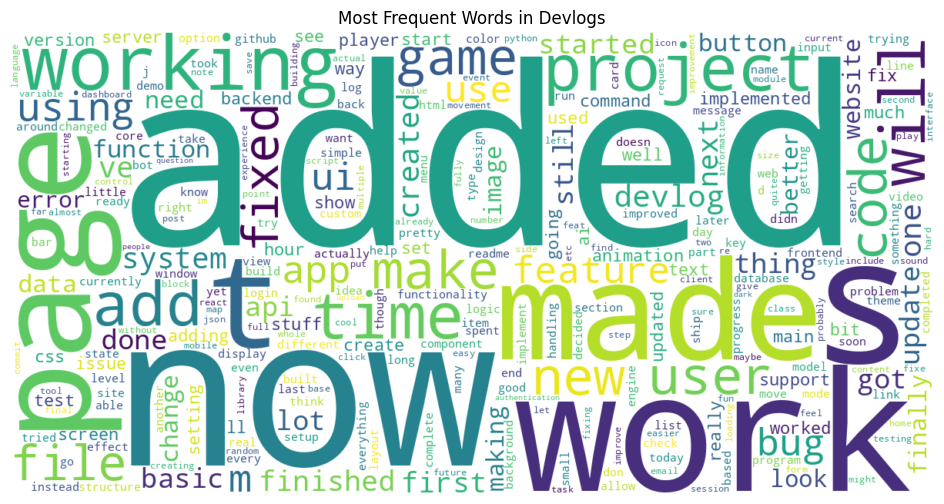

In [46]:
text_cols = [c for c in ['text', 'content',
                         'body', 'message'] if c in df.columns]
texts = (
    df[text_cols].astype(str).agg(' '.join, axis=1)
    if text_cols else pd.Series([], dtype=str)
)

# Basic cleaning
corpus = ' '.join(texts.dropna().tolist())
corpus = re.sub(r"https?://\S+", " ", corpus)
corpus = re.sub(r"[^A-Za-z0-9_+#-]+", " ", corpus)
corpus = re.sub(r"\s+", " ", corpus).strip().lower()


if corpus:
    wc = WordCloud(
        width=1200, height=600, background_color='white',
        collocations=False, max_words=300
    ).generate(corpus)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words in Devlogs')
    plt.show()
else:
    print('No devlog text columns found or text is empty. Expected one of:', text_cols)

In [47]:
_df = df.copy()

if 'text_length' not in _df.columns:
    candidates = [c for c in ['text', 'content',
                              'body', 'message'] if c in _df.columns]
    if candidates:
        txt = _df[candidates].astype(str).agg(' '.join, axis=1)
        _df['text_length'] = txt.fillna('').str.len()
    else:
        _df['text_length'] = pd.NA

_df['time_minutes_num'] = pd.to_numeric(
    _df.get('time_minutes'), errors='coerce')
if 'engagement' in _df.columns:
    _df['engagement_num'] = pd.to_numeric(_df['engagement'], errors='coerce')
elif 'likes_count' in _df.columns:
    _df['engagement_num'] = pd.to_numeric(_df['likes_count'], errors='coerce')

# 1) Histogram of text length
s = pd.to_numeric(_df['text_length'], errors='coerce')
fig = px.histogram(
    s.dropna(), nbins=50, title='Distribution of Devlog Text Length',
    labels={'value': 'Characters', 'count': 'Devlogs'}, color_discrete_sequence=['#636EFA']
)
fig.update_layout(showlegend=False)
fig.update_traces(marker_line_color='white', marker_line_width=0.5)
fig.update_layout(template='plotly_white', height=400)
fig.show()

# 2) Scatter: text length vs time
plot_df = _df.dropna(subset=['text_length', 'time_minutes_num']).copy()
fig = px.scatter(plot_df, x='text_length', y='time_minutes_num', trendline='ols',
                 title='Text Length vs Time Spent',
                 labels={'text_length': 'Text length (chars)', 'time_minutes_num': 'Time (minutes)'})
fig.update_layout(template='plotly_white', height=420)
fig.show()

# 3) Scatter: text length vs engagement
if 'engagement_num' in _df.columns:
    plot_df = _df.dropna(subset=['text_length', 'engagement_num']).copy()
    fig = px.scatter(plot_df, x='text_length', y='engagement_num', trendline='ols',
                     title='Text Length vs Engagement',
                     labels={'text_length': 'Text length (chars)', 'engagement_num': 'Engagement'})
    fig.update_layout(template='plotly_white', height=420)
    fig.show()

# Category vs Engagement

Average engagement by category with 95% CI error bars (top categories for readability).


In [48]:
_df = df.copy()

if 'engagement' in _df.columns:
    _df['engagement_num'] = pd.to_numeric(_df['engagement'], errors='coerce')
elif 'likes_count' in _df.columns:
    _df['engagement_num'] = pd.to_numeric(_df['likes_count'], errors='coerce')
else:
    _df['engagement_num'] = pd.NA

agg = (
    _df.dropna(subset=['category', 'engagement_num'])
       .groupby('category', observed=False)['engagement_num']
       .agg(['mean', 'count', 'std'])
       .reset_index()
)
agg['se'] = (agg['std'].fillna(0) / np.sqrt(agg['count'].clip(lower=1)))
agg['ci95'] = 1.96 * agg['se']
agg = agg.sort_values('mean', ascending=False)

TOP = 15
plot = agg.head(TOP)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=plot['category'], y=plot['mean'],
    error_y=dict(type='data', array=plot['ci95'], visible=True),
    marker_color='#1F77B4', name='Avg engagement'
))
fig.update_layout(
    title=f'Average Engagement by Category (Top {TOP})', template='plotly_white', height=450,
    xaxis_title='Category', yaxis_title='Avg engagement', xaxis_tickangle=-30
)
fig.show()